# Detección de Anomalías con Isolation Forest

## Pseudocódigo Formal del Algoritmo Isolation Forest

**ALGORITMO** `IsolationForest(D, n_trees, sub_sample_size)`

**ENTRADA:**
- `D ← {x₁, x₂, …, xₙ}` (conjunto de datos con n observaciones)
- `n_trees` (número de árboles en el bosque)
- `sub_sample_size` (número de muestras por árbol)

**SALIDA:**
- `s(xᵢ)` → puntaje de anomalía para cada instancia `xᵢ ∈ D`

**PASOS:**

1. **PARA** `t = 1` **HASTA** `n_trees` **HACER**
   - Seleccionar una muestra aleatoria de tamaño `sub_sample_size`
   - `S ← MuestraAleatoria(D, sub_sample_size)`
   - Construir un árbol de aislamiento (Isolation Tree)
   - `T_t ← iTree(S)`

2. **PARA cada instancia** `xᵢ ∈ D` **HACER**
   - Calcular la longitud promedio del camino en todos los árboles
   - `h(xᵢ) ← promedio de la profundidad de xᵢ en todos los árboles T_t`
   - Calcular el puntaje de anomalía:
   - `s(xᵢ) ← 2^(-h(xᵢ)/c(n))`

3. **RETORNAR** `s(xᵢ)` para cada `xᵢ ∈ D`

In [ ]:
# Importación de librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Algoritmo de detección de anomalías
from sklearn.ensemble import IsolationForest

# Carga de datos - application_train
df_train = pd.read_csv("../../data/data/application_train.csv")

# Mostrar información básica
print("Shape de application_train:", df_train.shape)
print("\nPrimeras 5 filas:")
df_train.head()

Shape de application_train: (307511, 122)

Primeras 5 filas:


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
# Paso 1: Seleccionar solo columnas numericas
columnas_numericas = df_train.select_dtypes(include=[np.number]).columns.tolist()

# Excluir columna identificadora
if 'SK_ID_CURR' in columnas_numericas:
    columnas_numericas.remove('SK_ID_CURR')

# Crear dataframe solo con variables numericas
df_numerico = df_train[columnas_numericas].copy()

print("Total de columnas numericas:", len(columnas_numericas))
print("Dimensiones del dataframe numerico:", df_numerico.shape)

Total de columnas numericas: 105
Dimensiones del dataframe numerico: (307511, 105)


In [4]:
# Paso 2: Analizar valores nulos en el dataset
total_nulos = df_numerico.isnull().sum()
columnas_con_nulos = total_nulos[total_nulos > 0]

print("Total de columnas con valores nulos:", len(columnas_con_nulos))
print("\nPrimeras 10 columnas con mas valores nulos:")
print(columnas_con_nulos.sort_values(ascending=False).head(10))

Total de columnas con valores nulos: 61

Primeras 10 columnas con mas valores nulos:
COMMONAREA_MODE             214865
COMMONAREA_MEDI             214865
COMMONAREA_AVG              214865
NONLIVINGAPARTMENTS_MODE    213514
NONLIVINGAPARTMENTS_AVG     213514
NONLIVINGAPARTMENTS_MEDI    213514
LIVINGAPARTMENTS_MEDI       210199
LIVINGAPARTMENTS_AVG        210199
LIVINGAPARTMENTS_MODE       210199
FLOORSMIN_MEDI              208642
dtype: int64


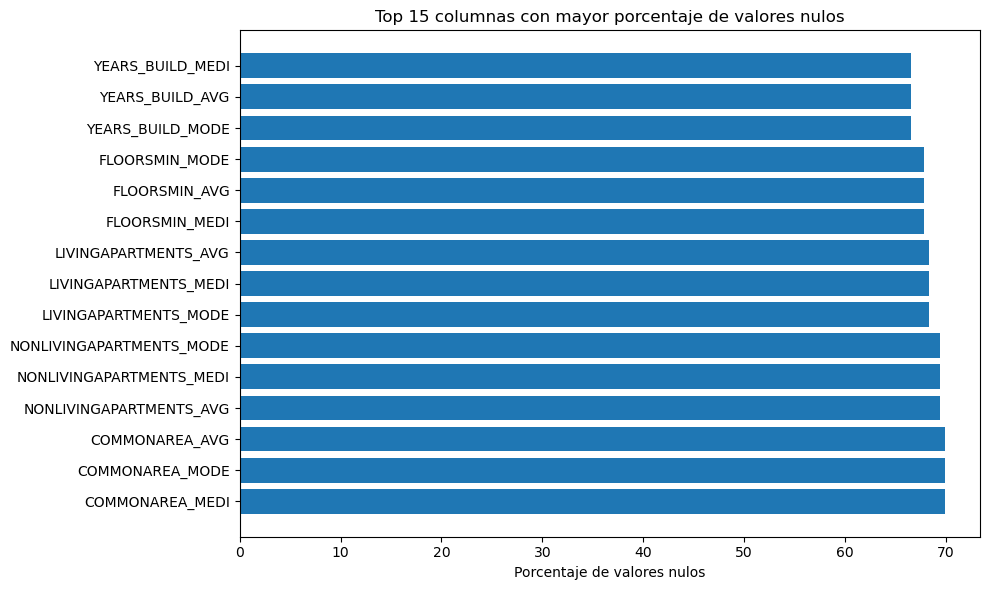

In [5]:
# Paso 3: Visualizar la distribucion de valores nulos
porcentaje_nulos = (df_numerico.isnull().sum() / len(df_numerico) * 100).sort_values(ascending=False)
top_nulos = porcentaje_nulos.head(15)

plt.figure(figsize=(10, 6))
plt.barh(range(len(top_nulos)), top_nulos.values)
plt.yticks(range(len(top_nulos)), top_nulos.index)
plt.xlabel('Porcentaje de valores nulos')
plt.title('Top 15 columnas con mayor porcentaje de valores nulos')
plt.tight_layout()
plt.show()

In [6]:
# Paso 4: Tratamiento de valores nulos - Imputacion con la mediana
print("Aplicando imputacion con la mediana")
df_numerico_limpio = df_numerico.fillna(df_numerico.median())

print("Imputacion completada")

Aplicando imputacion con la mediana
Imputacion completada
Imputacion completada


In [7]:
# Paso 5: Verificar que no queden valores nulos
nulos_restantes = df_numerico_limpio.isnull().sum().sum()

print("Total de valores nulos despues de la imputacion:", nulos_restantes)
print("Dimensiones finales:", df_numerico_limpio.shape)

Total de valores nulos despues de la imputacion: 0
Dimensiones finales: (307511, 105)


In [9]:
# Paso 6: Preparar conjunto de datos final para Isolation Forest
# Tomar muestra del dataset
muestra_size = 10000
if len(df_numerico_limpio) > muestra_size:
    df_if = df_numerico_limpio.sample(n=muestra_size, random_state=42)
    print(f"Muestra aleatoria de {muestra_size} registros creada")
else:
    df_if = df_numerico_limpio.copy()
    print(f"Se usara el dataset completo ({len(df_if)} registros)")

# Renombrar TODAS las variables a español para mejor interpretacion
nombres_espanol = {
    'TARGET': 'objetivo',
    'CNT_CHILDREN': 'num_hijos',
    'AMT_INCOME_TOTAL': 'ingreso_total',
    'AMT_CREDIT': 'monto_credito',
    'AMT_ANNUITY': 'anualidad',
    'AMT_GOODS_PRICE': 'precio_bienes',
    'REGION_POPULATION_RELATIVE': 'poblacion_region',
    'DAYS_BIRTH': 'edad_dias',
    'DAYS_EMPLOYED': 'dias_empleado',
    'DAYS_REGISTRATION': 'dias_registro',
    'DAYS_ID_PUBLISH': 'dias_publicacion_id',
    'OWN_CAR_AGE': 'edad_auto',
    'FLAG_MOBIL': 'tiene_movil',
    'FLAG_EMP_PHONE': 'tiene_telefono_trabajo',
    'FLAG_WORK_PHONE': 'tiene_telefono_casa',
    'FLAG_CONT_MOBILE': 'movil_alcanzable',
    'FLAG_PHONE': 'tiene_telefono',
    'FLAG_EMAIL': 'tiene_email',
    'CNT_FAM_MEMBERS': 'num_miembros_familia',
    'REGION_RATING_CLIENT': 'calificacion_region',
    'REGION_RATING_CLIENT_W_CITY': 'calificacion_region_ciudad',
    'HOUR_APPR_PROCESS_START': 'hora_solicitud',
    'REG_REGION_NOT_LIVE_REGION': 'region_diferente_residencia',
    'REG_REGION_NOT_WORK_REGION': 'region_diferente_trabajo',
    'LIVE_REGION_NOT_WORK_REGION': 'residencia_diferente_trabajo',
    'REG_CITY_NOT_LIVE_CITY': 'ciudad_diferente_residencia',
    'REG_CITY_NOT_WORK_CITY': 'ciudad_diferente_trabajo',
    'LIVE_CITY_NOT_WORK_CITY': 'ciudad_residencia_diferente_trabajo',
    'EXT_SOURCE_1': 'fuente_externa_1',
    'EXT_SOURCE_2': 'fuente_externa_2',
    'EXT_SOURCE_3': 'fuente_externa_3',
    'APARTMENTS_AVG': 'apartamentos_promedio',
    'BASEMENTAREA_AVG': 'area_sotano_promedio',
    'YEARS_BEGINEXPLUATATION_AVG': 'anos_inicio_explotacion_promedio',
    'YEARS_BUILD_AVG': 'anos_construccion_promedio',
    'COMMONAREA_AVG': 'area_comun_promedio',
    'ELEVATORS_AVG': 'elevadores_promedio',
    'ENTRANCES_AVG': 'entradas_promedio',
    'FLOORSMAX_AVG': 'pisos_max_promedio',
    'FLOORSMIN_AVG': 'pisos_min_promedio',
    'LANDAREA_AVG': 'area_terreno_promedio',
    'LIVINGAPARTMENTS_AVG': 'apartamentos_habitables_promedio',
    'LIVINGAREA_AVG': 'area_habitable_promedio',
    'NONLIVINGAPARTMENTS_AVG': 'apartamentos_no_habitables_promedio',
    'NONLIVINGAREA_AVG': 'area_no_habitable_promedio',
    'APARTMENTS_MODE': 'apartamentos_moda',
    'BASEMENTAREA_MODE': 'area_sotano_moda',
    'YEARS_BEGINEXPLUATATION_MODE': 'anos_inicio_explotacion_moda',
    'YEARS_BUILD_MODE': 'anos_construccion_moda',
    'COMMONAREA_MODE': 'area_comun_moda',
    'ELEVATORS_MODE': 'elevadores_moda',
    'ENTRANCES_MODE': 'entradas_moda',
    'FLOORSMAX_MODE': 'pisos_max_moda',
    'FLOORSMIN_MODE': 'pisos_min_moda',
    'LANDAREA_MODE': 'area_terreno_moda',
    'LIVINGAPARTMENTS_MODE': 'apartamentos_habitables_moda',
    'LIVINGAREA_MODE': 'area_habitable_moda',
    'NONLIVINGAPARTMENTS_MODE': 'apartamentos_no_habitables_moda',
    'NONLIVINGAREA_MODE': 'area_no_habitable_moda',
    'APARTMENTS_MEDI': 'apartamentos_mediana',
    'BASEMENTAREA_MEDI': 'area_sotano_mediana',
    'YEARS_BEGINEXPLUATATION_MEDI': 'anos_inicio_explotacion_mediana',
    'YEARS_BUILD_MEDI': 'anos_construccion_mediana',
    'COMMONAREA_MEDI': 'area_comun_mediana',
    'ELEVATORS_MEDI': 'elevadores_mediana',
    'ENTRANCES_MEDI': 'entradas_mediana',
    'FLOORSMAX_MEDI': 'pisos_max_mediana',
    'FLOORSMIN_MEDI': 'pisos_min_mediana',
    'LANDAREA_MEDI': 'area_terreno_mediana',
    'LIVINGAPARTMENTS_MEDI': 'apartamentos_habitables_mediana',
    'LIVINGAREA_MEDI': 'area_habitable_mediana',
    'NONLIVINGAPARTMENTS_MEDI': 'apartamentos_no_habitables_mediana',
    'NONLIVINGAREA_MEDI': 'area_no_habitable_mediana',
    'FONDKAPREMONT_MODE': 'fondo_reparaciones_moda',
    'HOUSETYPE_MODE': 'tipo_casa_moda',
    'TOTALAREA_MODE': 'area_total_moda',
    'WALLSMATERIAL_MODE': 'material_paredes_moda',
    'EMERGENCYSTATE_MODE': 'estado_emergencia_moda',
    'OBS_30_CNT_SOCIAL_CIRCLE': 'obs_30dias_circulo_social',
    'DEF_30_CNT_SOCIAL_CIRCLE': 'def_30dias_circulo_social',
    'OBS_60_CNT_SOCIAL_CIRCLE': 'obs_60dias_circulo_social',
    'DEF_60_CNT_SOCIAL_CIRCLE': 'def_60dias_circulo_social',
    'DAYS_LAST_PHONE_CHANGE': 'dias_ultimo_cambio_telefono',
    'FLAG_DOCUMENT_2': 'tiene_documento_2',
    'FLAG_DOCUMENT_3': 'tiene_documento_3',
    'FLAG_DOCUMENT_4': 'tiene_documento_4',
    'FLAG_DOCUMENT_5': 'tiene_documento_5',
    'FLAG_DOCUMENT_6': 'tiene_documento_6',
    'FLAG_DOCUMENT_7': 'tiene_documento_7',
    'FLAG_DOCUMENT_8': 'tiene_documento_8',
    'FLAG_DOCUMENT_9': 'tiene_documento_9',
    'FLAG_DOCUMENT_10': 'tiene_documento_10',
    'FLAG_DOCUMENT_11': 'tiene_documento_11',
    'FLAG_DOCUMENT_12': 'tiene_documento_12',
    'FLAG_DOCUMENT_13': 'tiene_documento_13',
    'FLAG_DOCUMENT_14': 'tiene_documento_14',
    'FLAG_DOCUMENT_15': 'tiene_documento_15',
    'FLAG_DOCUMENT_16': 'tiene_documento_16',
    'FLAG_DOCUMENT_17': 'tiene_documento_17',
    'FLAG_DOCUMENT_18': 'tiene_documento_18',
    'FLAG_DOCUMENT_19': 'tiene_documento_19',
    'FLAG_DOCUMENT_20': 'tiene_documento_20',
    'FLAG_DOCUMENT_21': 'tiene_documento_21',
    'AMT_REQ_CREDIT_BUREAU_HOUR': 'consultas_buro_ultima_hora',
    'AMT_REQ_CREDIT_BUREAU_DAY': 'consultas_buro_ultimo_dia',
    'AMT_REQ_CREDIT_BUREAU_WEEK': 'consultas_buro_ultima_semana',
    'AMT_REQ_CREDIT_BUREAU_MON': 'consultas_buro_ultimo_mes',
    'AMT_REQ_CREDIT_BUREAU_QRT': 'consultas_buro_ultimo_trimestre',
    'AMT_REQ_CREDIT_BUREAU_YEAR': 'consultas_buro_ultimo_ano'
}

# Aplicar renombrado solo a columnas que existen
columnas_renombrar = {k: v for k, v in nombres_espanol.items() if k in df_if.columns}
df_if = df_if.rename(columns=columnas_renombrar)

print(f"\nVariables renombradas a español: {len(columnas_renombrar)} de {df_if.shape[1]}")

Muestra aleatoria de 10000 registros creada

Variables renombradas a español: 105 de 105


In [10]:
# Paso 8: Aplicación del Pseudocódigo - Definir conjunto D y parámetros
D = df_if.copy()

# Parámetros del algoritmo Isolation Forest
n_trees = 100  # número de árboles en el bosque
sub_sample_size = 256  # número de muestras por árbol

print(f"Conjunto D preparado con {D.shape[0]} observaciones y {D.shape[1]} características")
print(f"Parámetros: n_trees={n_trees}, sub_sample_size={sub_sample_size}")

Conjunto D preparado con 10000 observaciones y 105 características
Parámetros: n_trees=100, sub_sample_size=256


In [11]:
# Paso 9: Construir el bosque de árboles de aislamiento
modelo_if = IsolationForest(
    n_estimators=n_trees,
    max_samples=sub_sample_size,
    contamination='auto',
    random_state=42
)

etiquetas = modelo_if.fit_predict(D)

In [12]:
# Paso 10: Calcular puntajes de anomalía
scores_if = -modelo_if.score_samples(D)

# Agregar resultados al dataframe
D['score_anomalia'] = scores_if
D['es_anomalia'] = etiquetas
D['es_anomalia'] = D['es_anomalia'].map({1: 'Normal', -1: 'Anomalía'})

In [13]:
# Paso 11: Análisis de resultados
num_anomalias = (D['es_anomalia'] == 'Anomalía').sum()
porcentaje_anomalias = (num_anomalias / len(D)) * 100

print(f"Detección completada:")
print(f"  Total de anomalías detectadas: {num_anomalias}")
print(f"  Porcentaje: {porcentaje_anomalias:.2f}%")
print(f"\nTop 10 anomalías con mayor puntaje:")
print(D.nlargest(10, 'score_anomalia')[['score_anomalia', 'es_anomalia']].to_string())

Detección completada:
  Total de anomalías detectadas: 434
  Porcentaje: 4.34%

Top 10 anomalías con mayor puntaje:
        score_anomalia es_anomalia
210630        0.700505    Anomalía
37437         0.688514    Anomalía
201384        0.676294    Anomalía
194458        0.675470    Anomalía
46619         0.673718    Anomalía
148095        0.673005    Anomalía
67044         0.670461    Anomalía
16992         0.665516    Anomalía
63398         0.663320    Anomalía
141526        0.662387    Anomalía


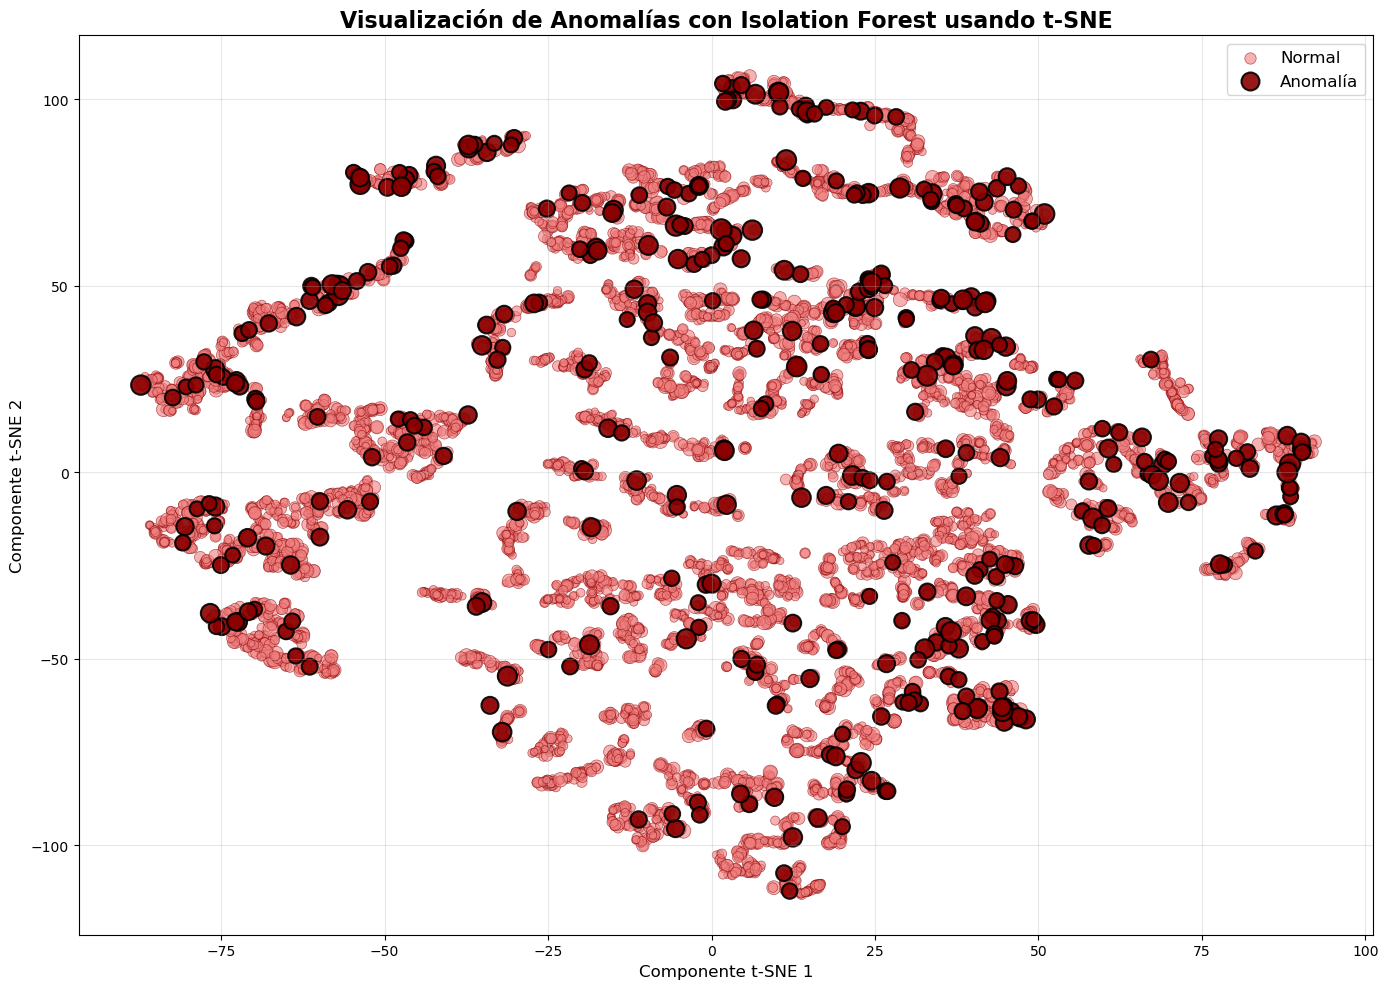

Visualización guardada en '../results/if_visualizacion.png'


In [ ]:
# Paso 12: Visualización con t-SNE
from sklearn.manifold import TSNE

# Aplicar t-SNE para reducción dimensional
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
D_reducido = tsne.fit_transform(D.drop(['score_anomalia', 'es_anomalia'], axis=1))

# Crear la visualización
plt.figure(figsize=(14, 10))

# Separar datos normales y anomalías
normales = D['es_anomalia'] == 'Normal'
anomalias = D['es_anomalia'] == 'Anomalía'

# Normalizar scores para el tamaño de los círculos
scores_norm = (D['score_anomalia'] - D['score_anomalia'].min()) / (D['score_anomalia'].max() - D['score_anomalia'].min())
tamaños = 20 + scores_norm * 200

# Graficar puntos normales (azul para Isolation Forest)
plt.scatter(D_reducido[normales, 0], D_reducido[normales, 1],
           c='lightblue', s=tamaños[normales], alpha=0.6,
           edgecolors='blue', linewidth=0.5, label='Normal')

# Graficar anomalías (naranja para Isolation Forest)
plt.scatter(D_reducido[anomalias, 0], D_reducido[anomalias, 1],
           c='orange', s=tamaños[anomalias], alpha=0.9,
           edgecolors='darkred', linewidth=1.5, label='Anomalía', marker='o')

plt.title('Visualización de Anomalías con Isolation Forest usando t-SNE', fontsize=16, fontweight='bold')
plt.xlabel('Componente t-SNE 1', fontsize=12)
plt.ylabel('Componente t-SNE 2', fontsize=12)
plt.legend(loc='best', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

c:\Users\EQUIPO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\EQUIPO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\EQUIPO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\EQUIPO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\EQUIPO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\EQUIPO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have v

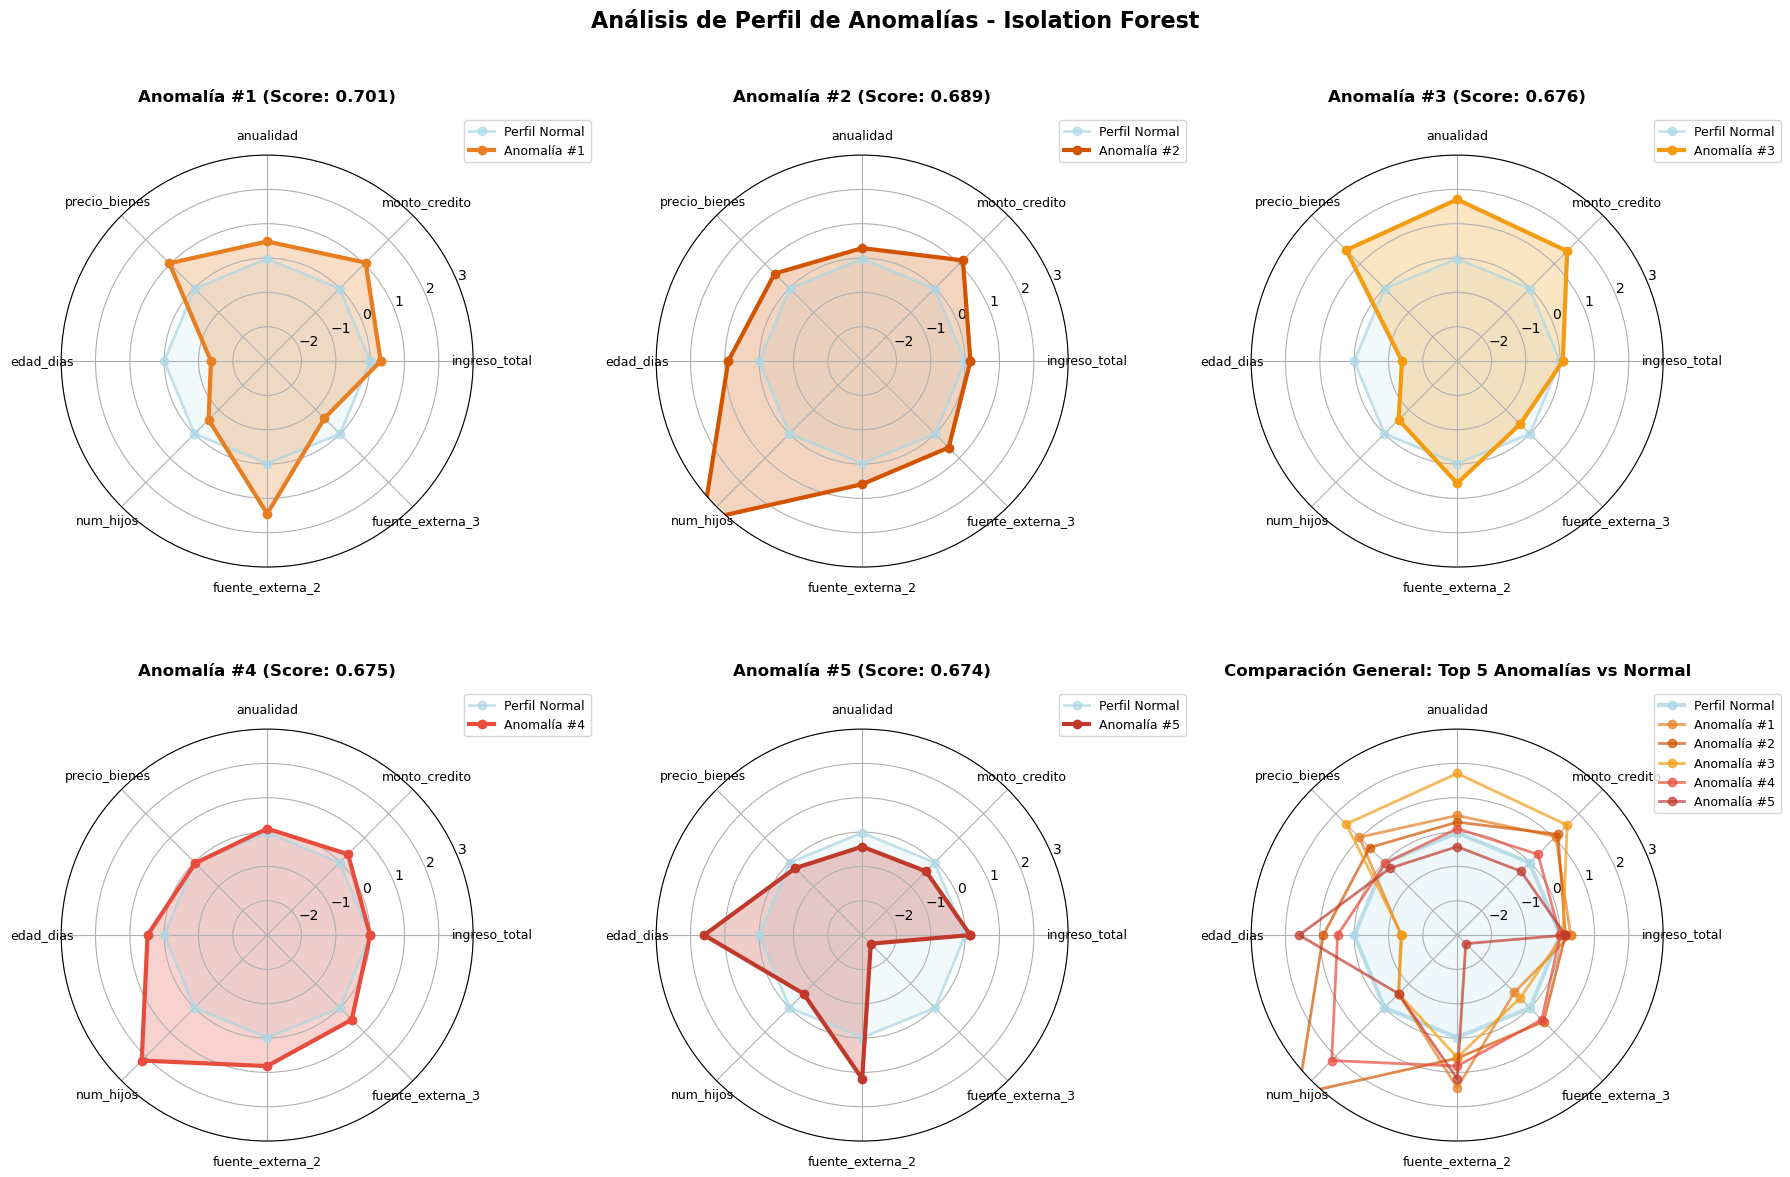

Gráfico de radar guardado en '../results/if_radar_anomalias.png'


In [ ]:
# Paso 13: Gráfico de Radar para entender el contexto de las anomalías
from sklearn.preprocessing import StandardScaler

# Seleccionar variables clave para analizar el perfil
vars_radar = ['ingreso_total', 'monto_credito', 'anualidad', 'precio_bienes', 
              'edad_dias', 'num_hijos', 'fuente_externa_2', 'fuente_externa_3']

# Verificar que existan las variables
vars_disponibles = [v for v in vars_radar if v in D.columns]

# Obtener top 5 anomalías
top_anomalias = D[D['es_anomalia'] == 'Anomalía'].nlargest(5, 'score_anomalia')

# Calcular perfil promedio de datos normales
perfil_normal = D[D['es_anomalia'] == 'Normal'][vars_disponibles].mean()

# Estandarizar valores para comparación
scaler = StandardScaler()
datos_radar = D[vars_disponibles].copy()
datos_estandarizados = scaler.fit_transform(datos_radar)
D_std = pd.DataFrame(datos_estandarizados, columns=vars_disponibles, index=D.index)

# Crear gráfico de radar con 6 subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 12), subplot_kw=dict(projection='polar'))
axes = axes.flatten()

colores = ['#e67e22', '#d35400', '#f39c12', '#e74c3c', '#c0392b']

# Gráfico individual para cada una de las top 5 anomalías
for idx, (_, anomalia) in enumerate(top_anomalias.iterrows()):
    ax = axes[idx]
    
    # Preparar datos
    categorias = vars_disponibles
    N = len(categorias)
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]
    
    # Valores de la anomalía y perfil normal
    valores_anomalia = D_std.loc[anomalia.name, vars_disponibles].values.tolist()
    valores_anomalia += valores_anomalia[:1]
    
    valores_normal = scaler.transform([perfil_normal.values])[0].tolist()
    valores_normal += valores_normal[:1]
    
    # Graficar perfil normal
    ax.plot(angles, valores_normal, 'o-', linewidth=2, label='Perfil Normal', color='lightblue', alpha=0.7)
    ax.fill(angles, valores_normal, alpha=0.15, color='lightblue')
    
    # Graficar anomalía
    color = colores[idx]
    ax.plot(angles, valores_anomalia, 'o-', linewidth=3, label=f'Anomalía #{idx+1}', color=color)
    ax.fill(angles, valores_anomalia, alpha=0.25, color=color)
    
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categorias, size=9)
    ax.set_ylim(-3, 3)
    ax.set_title(f'Anomalía #{idx+1} (Score: {anomalia["score_anomalia"]:.3f})', 
                 size=12, fontweight='bold', pad=20)
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=9)
    ax.grid(True)

# Gráfico comparativo general (subplot 6)
ax = axes[5]
angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1]

valores_normal = scaler.transform([perfil_normal.values])[0].tolist()
valores_normal += valores_normal[:1]

ax.plot(angles, valores_normal, 'o-', linewidth=3, label='Perfil Normal', color='lightblue', alpha=0.8)
ax.fill(angles, valores_normal, alpha=0.2, color='lightblue')

for idx, (_, anomalia) in enumerate(top_anomalias.iterrows()):
    valores_anomalia = D_std.loc[anomalia.name, vars_disponibles].values.tolist()
    valores_anomalia += valores_anomalia[:1]
    ax.plot(angles, valores_anomalia, 'o-', linewidth=2, label=f'Anomalía #{idx+1}', 
            color=colores[idx], alpha=0.7)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(categorias, size=9)
ax.set_ylim(-3, 3)
ax.set_title('Comparación General: Top 5 Anomalías vs Normal', 
             size=12, fontweight='bold', pad=20)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=9)
ax.grid(True)

plt.suptitle('Análisis de Perfil de Anomalías - Isolation Forest', 
             fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()